In [1]:
# Timestamp is the time the I/O was issued in "Windows filetime"
# Hostname is the hostname (should be the same as that in the trace file name)
# DiskNumber is the disknumber (should be the same as in the trace file name)
# Type is "Read" or "Write"
# Offset is the starting offset of the I/O in bytes from the start of the logical
# disk.
# Size is the transfer size of the I/O request in bytes.
# ResponseTime is the time taken by the I/O to complete, in Windows filetime
# units.

## Trace analysis - 7 Days

### All accesses wrt each block

In [2]:
# URL - http://iotta.snia.org/traces/388



# Graph References - MSR Paper - https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4636097


# Starting Time - 2007-02-22 19:55:39.434557
# Ending Time - 2007-03-01 17:22:03.093349




# Make 3 maps, read-only, write-only, both


import pandas as pd
import math
import collections
from datetime import datetime, timedelta


import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(14,40)})


data = pd.read_csv('hm_1.csv', names=["Timestamp", "Hostname", "DiskNumber", "Type", "Offset", "Size", "ResponseTime"])
# data.head()
data.shape

(609311, 7)

In [3]:
# PART 1 - All Access

block_counter_dict = {}
block_read_counter_dict = {}
block_write_counter_dict = {}

for row in data.itertuples():
        
    # taking block size = 4KB
    
    block_index = int(row.Offset / 4096)

    
    
    flag_r = False
    if (row.Type == 'Read'):
        flag_r = True  # else flag = Write  

#     if (block_index in block_counter_dict):
#         block_counter_dict[block_index] += 1
#     else:
#         block_counter_dict[block_index] = 1





        
    # using offset iterate over the next blocks
    next_blocks_count = int(row.Size / 4096)

    # Incrememnt next blocks counter ------- start from 1 as 0th block already added
    for i in range(0, next_blocks_count):
        # Already done for 0th block
#         if (i == 0):
#             continue
        if (block_index+i in block_counter_dict):
            block_counter_dict[block_index+i] += 1
        else:
            block_counter_dict[block_index+i] = 1
            
            
            
        # Read and Write counters
    for i in range(0, next_blocks_count):
        if (flag_r):
            if (block_index+i in block_read_counter_dict):
                block_read_counter_dict[block_index+i] += 1
            else:
                block_read_counter_dict[block_index+i] = 1
        else:        # else means write
            if (block_index+i in block_write_counter_dict):
                block_write_counter_dict[block_index+i] += 1
            else:
                block_write_counter_dict[block_index+i] = 1
        
    
    
print ("Number of blocks accessed", len(block_counter_dict))
print ("Sum of all the block accesses", sum(block_counter_dict.values()))
# print (block_counter_dict)




# for key in sorted(block_counter_dict):
#     print ("%s: %s" % (key, block_counter_dict[key]))

sorted_block_counter_dict = collections.OrderedDict(sorted(block_counter_dict.items()))
sorted_block_read_counter_dict = collections.OrderedDict(sorted(block_read_counter_dict.items()))
sorted_block_write_counter_dict = collections.OrderedDict(sorted(block_write_counter_dict.items()))

# print(sorted_block_counter_dict)

# print(sorted(block_counter_dict.values(), reverse=True))

Number of blocks accessed 51733
Sum of all the block accesses 2308560


In [4]:
# df = pd.DataFrame(sorted_block_counter_dict, index=[1])
# df = pd.DataFrame.from_dict(sorted_block_counter_dict.items(), orient='index')
sorted_df = pd.DataFrame.from_dict(sorted_block_counter_dict, orient='index')

print(sorted_df)


sorted_read_df = pd.DataFrame.from_dict(sorted_block_read_counter_dict, orient='index')
sorted_write_df = pd.DataFrame.from_dict(sorted_block_write_counter_dict, orient='index')

          0
6         4
81       40
82       40
83       40
84       40
...      ..
6667638  13
6667639   8
6667640  13
6667642   2
6667643  18

[51733 rows x 1 columns]


In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(sorted_df)

            0
6           4
81         40
82         40
83         40
84         40
85        129
86        129
87         40
88         40
89         40
90         40
91         48
92         48
93         39
94         39
95         40
96         40
97        348
98        348
99        675
100       675
101       293
102       293
103       248
104       248
105       598
106       598
107       205
108       205
109       248
110       248
111       208
112       208
113       324
114       324
115       183
116       183
117      1538
118      1538
119      1557
120      1557
121       604
122       604
123       186
124       186
125       173
126       173
127       207
128       207
129      1418
130      1418
131      1422
132      1422
133        97
134        97
135        72
136        72
137       284
138       284
139       280
140       280
141        71
142        71
143        71
144        71
145       271
146       271
147       260
148       260
149       255
150   

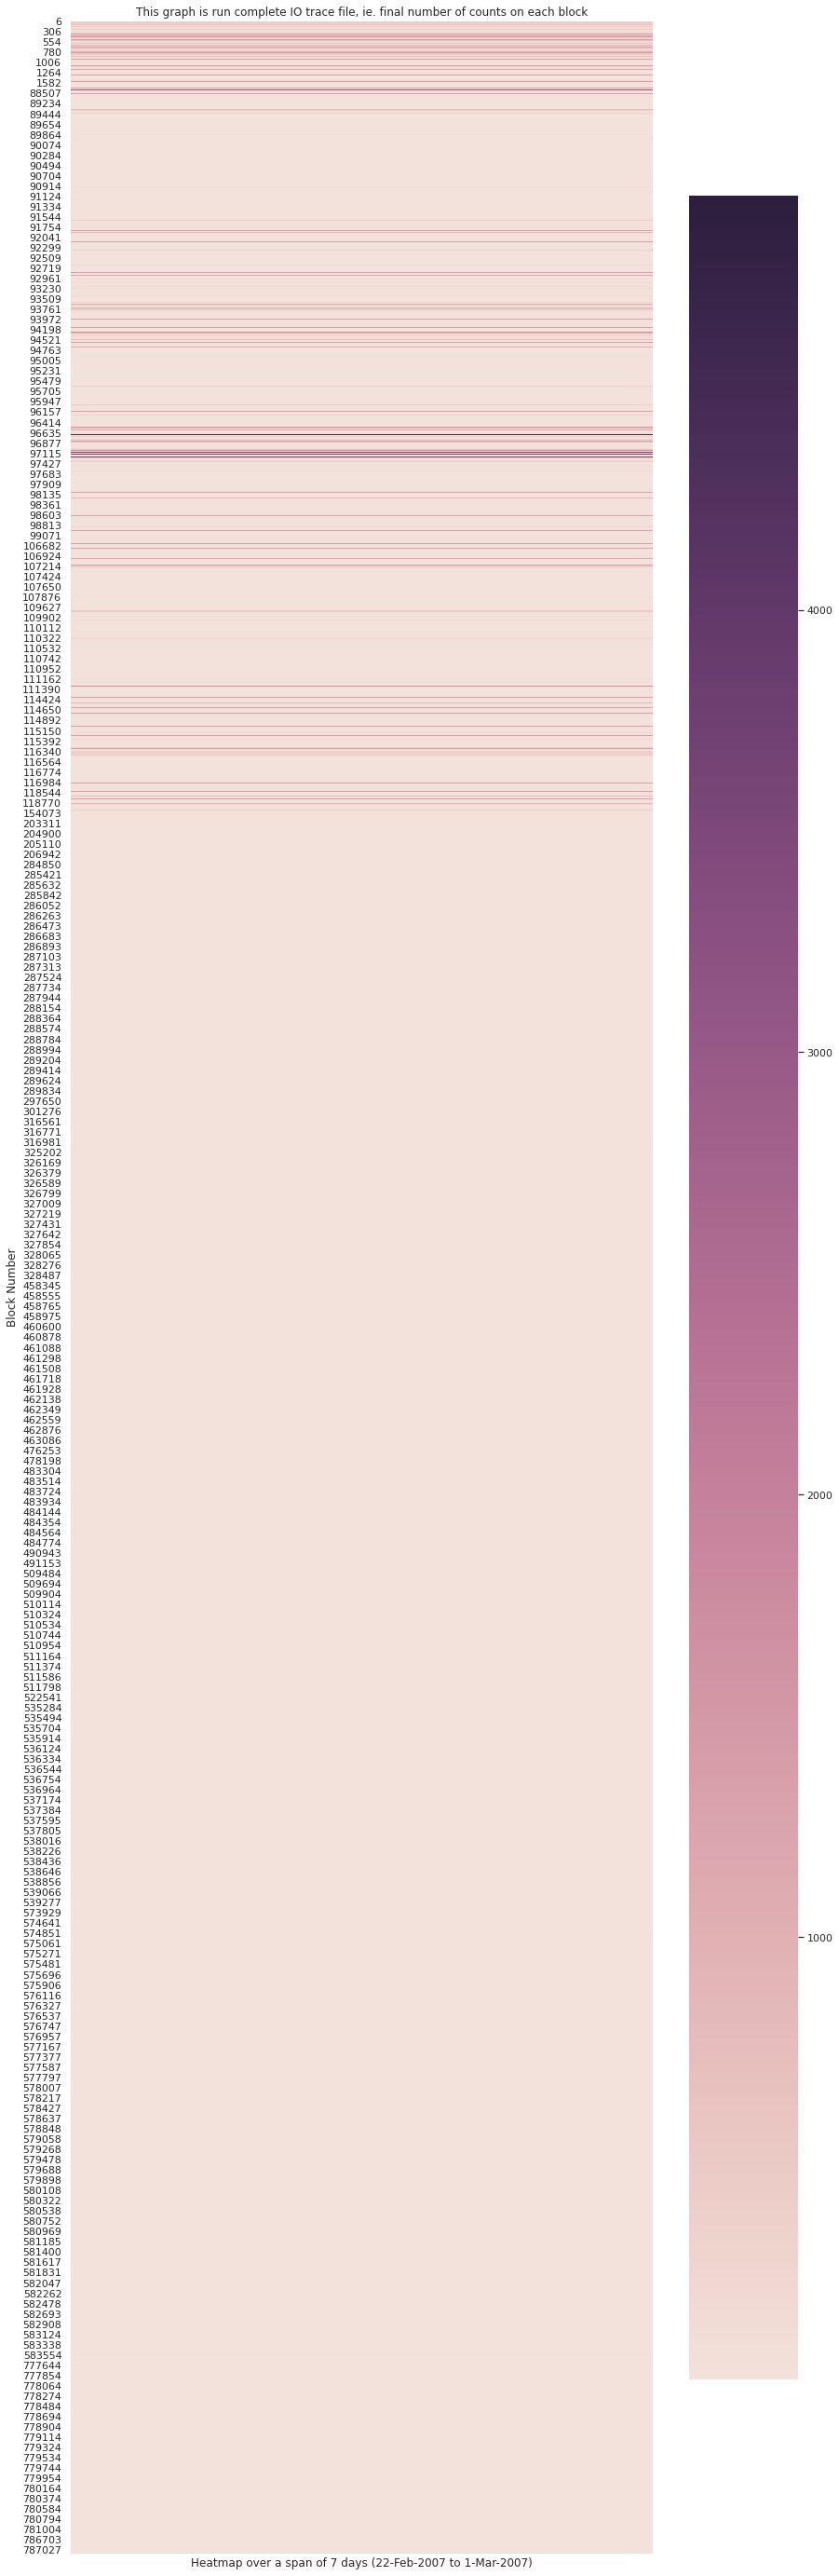

In [6]:
sns.set(rc={'figure.figsize':(14,50)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(sorted_df, cmap=cmap_i, xticklabels=False)

plt.xlabel('Heatmap over a span of 7 days (22-Feb-2007 to 1-Mar-2007)')
plt.ylabel('Block Number')
plt.title('This graph is run complete IO trace file, ie. final number of counts on each block')
plt.show()


### Plot of number of reads and writes wrt each block

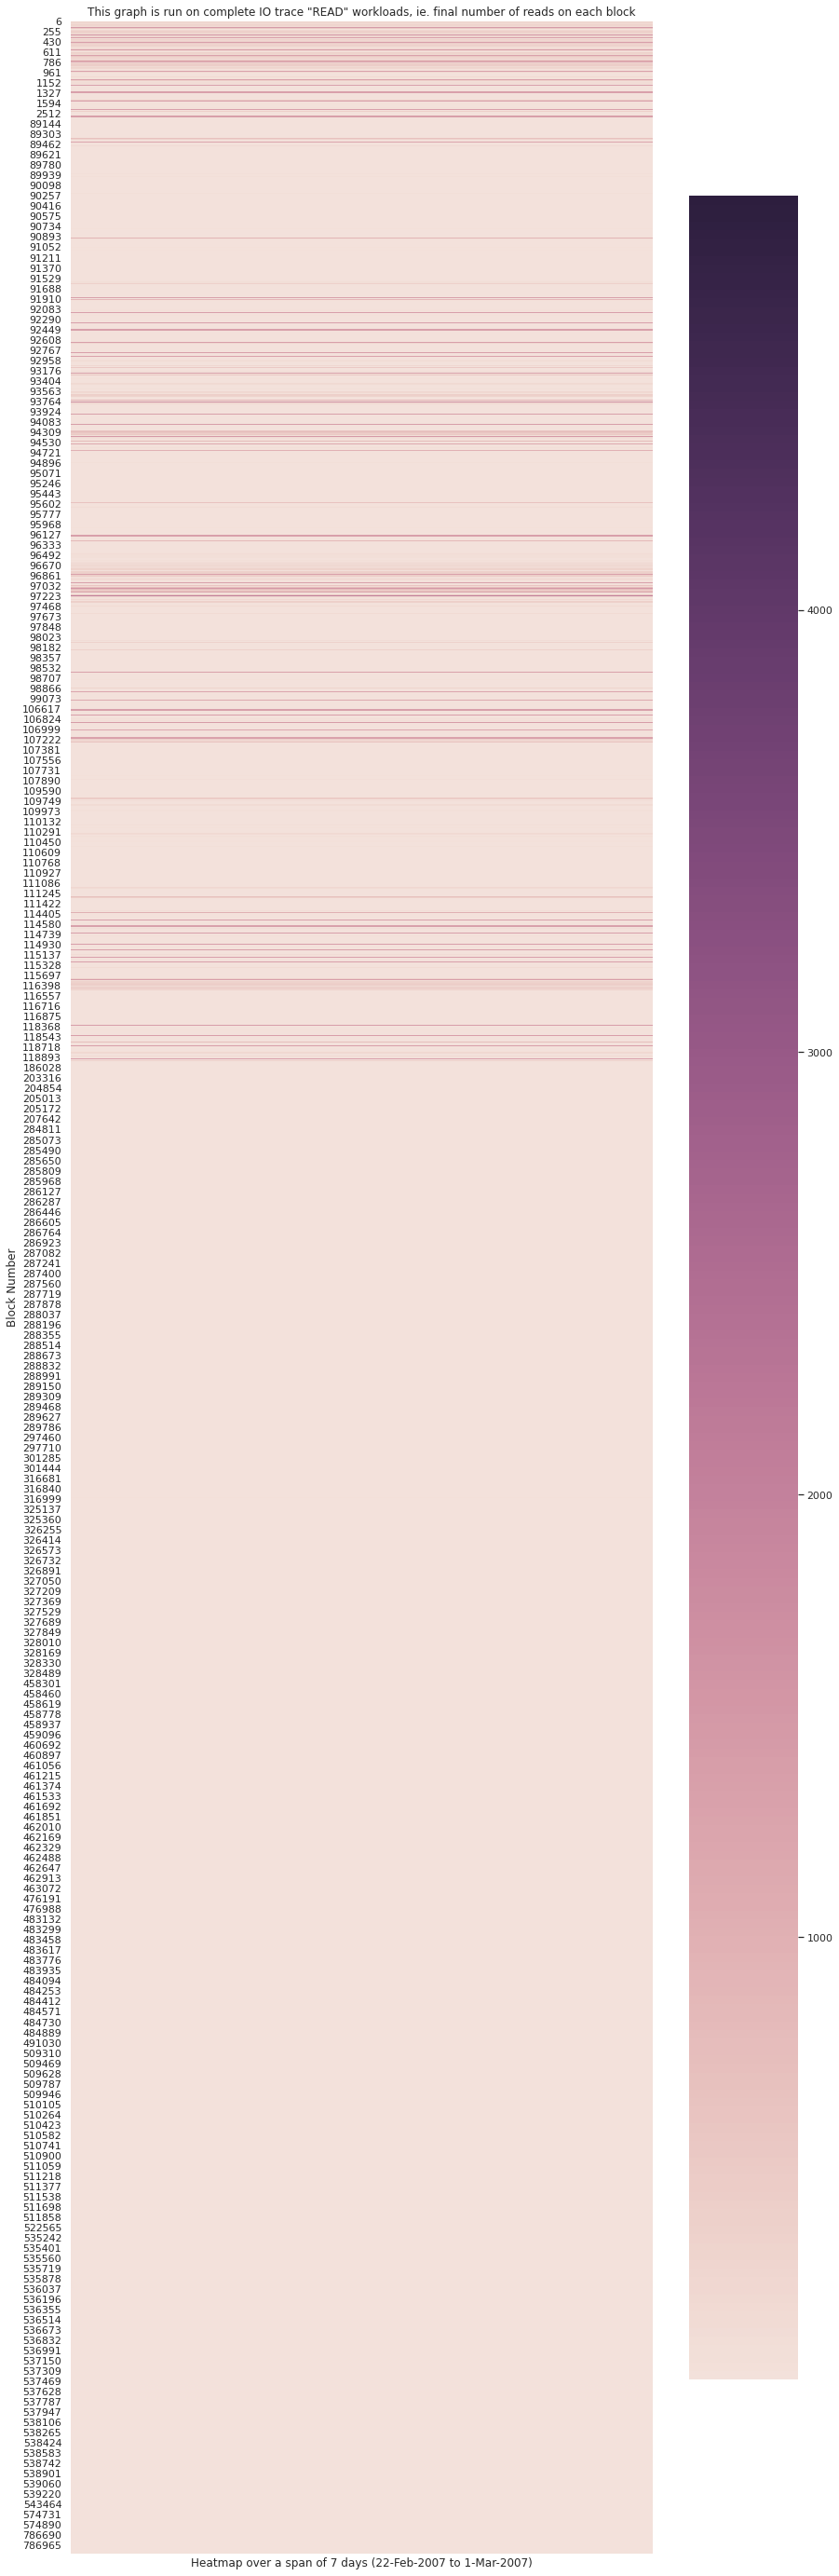

In [7]:
sns.set(rc={'figure.figsize':(14,50)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(sorted_read_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('Heatmap over a span of 7 days (22-Feb-2007 to 1-Mar-2007)')
plt.ylabel('Block Number')
plt.title('This graph is run on complete IO trace "READ" workloads, ie. final number of reads on each block')
plt.show()

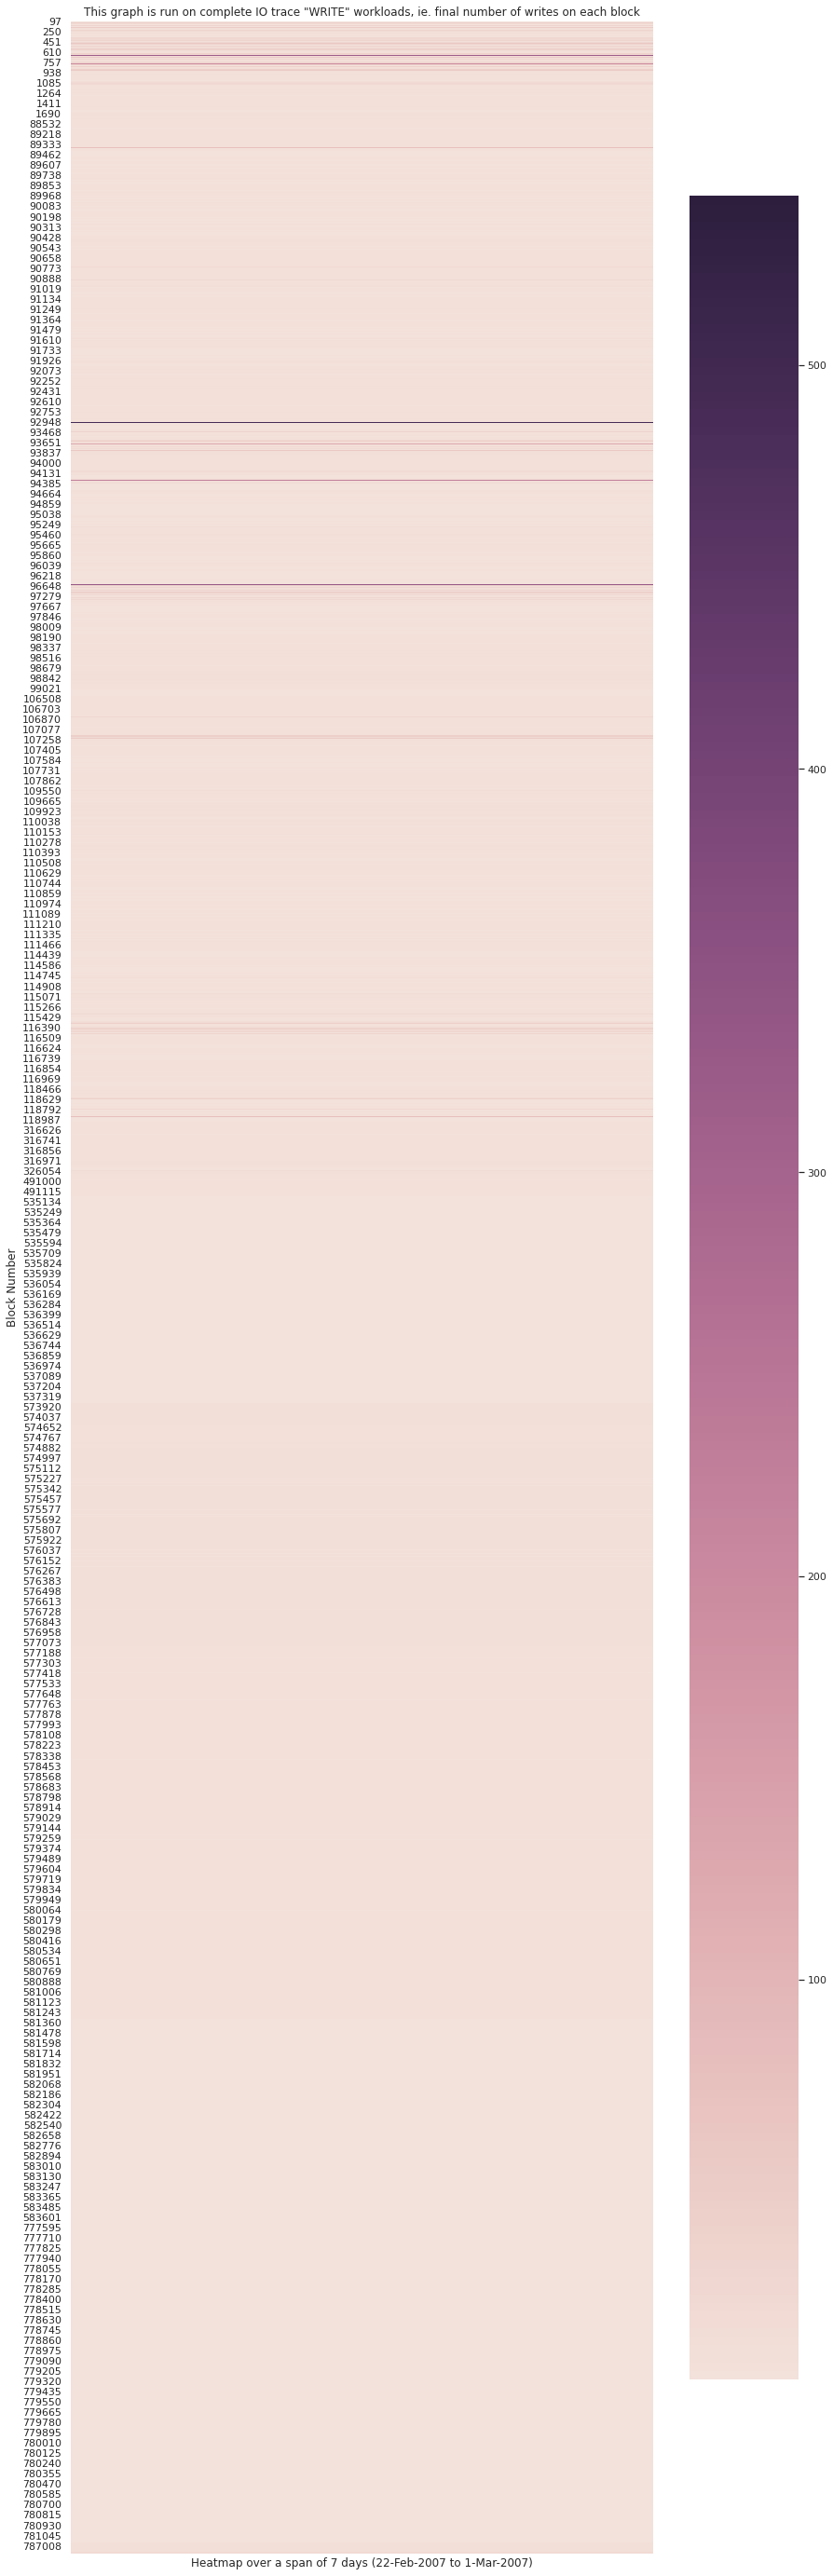

In [8]:
sns.set(rc={'figure.figsize':(14,50)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(sorted_write_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('Heatmap over a span of 7 days (22-Feb-2007 to 1-Mar-2007)')
plt.ylabel('Block Number')
plt.title('This graph is run on complete IO trace "WRITE" workloads, ie. final number of writes on each block')
plt.show()


## Trace Analysis - time series plot

### All accesses wrt each block


In [9]:
def convert_filetime_to_datetime(ft):
    return datetime.utcfromtimestamp((ft - 116444736000000000) / 10000000)


In [10]:
# Part 2 - This is time series data



# Reset all the values to zero
# new_block_dict = dict.fromkeys(sorted_block_counter_dict, 0)

set_pivot_timer = convert_filetime_to_datetime(data.Timestamp[0])
set_hours = 1
result_df = pd.DataFrame()
result_read_df = pd.DataFrame()
result_write_df = pd.DataFrame()

granularity_y_axis = 1000
granularity_x_axis = 20

time_series_dict = dict.fromkeys(range(granularity_y_axis+1), 0)
time_series_read_dict = dict.fromkeys(range(granularity_y_axis+1), 0)
time_series_write_dict = dict.fromkeys(range(granularity_y_axis+1), 0)

flag = False
dataframe_column_count = 0

# Now keep granularity_y_axis, i.e. block_ranges on y-axis for better visualisation
block_range_size = sorted_df.index[-1] // granularity_y_axis


for row in data.itertuples():
    
    # print (type(convert_filetime_to_datetime(row.Timestamp)), convert_filetime_to_datetime(row.Timestamp))
    

    
    # Time visualisation can be seen in above print statement - Collect trace map for every X-hrs
    current_io_time = convert_filetime_to_datetime(row.Timestamp)
    if abs(current_io_time - set_pivot_timer) > timedelta(hours=set_hours):
        # 6 hours limit crossed, set a flag and record new entries
        flag = True
        df = pd.DataFrame.from_dict(time_series_dict, orient='index')
        result_df[dataframe_column_count] = df[0].values
        
        df = pd.DataFrame.from_dict(time_series_read_dict, orient='index')
        result_read_df[dataframe_column_count] = df[0].values
        
        df = pd.DataFrame.from_dict(time_series_write_dict, orient='index')
        result_write_df[dataframe_column_count] = df[0].values
        
        # update pivot timer to current one
        set_pivot_timer = current_io_time
        print ("set_pivot_timer", set_pivot_timer)
        
        dataframe_column_count += 1
        
        
        
        
        
    # Reintialize dict if just copied to dataframe    
    if flag == True:
        time_series_dict = dict.fromkeys(range(granularity_y_axis + 1), 0)
        time_series_read_dict = dict.fromkeys(range(granularity_y_axis + 1), 0)
        time_series_write_dict = dict.fromkeys(range(granularity_y_axis + 1), 0)
        flag = False
    
    
    
    
    # taking block size = 4KB    
    block_index = row.Offset // 4096
    # using offset iterate over the next blocks
    next_blocks_count = row.Size // 4096

    
    
    
    # Increment next blocks counter -------
    for i in range(0, next_blocks_count):
        time_series_dict[(block_index+i) // block_range_size] += 1
        if (row.Type == "Read"):
            time_series_read_dict[(block_index+i) // block_range_size] += 1
        else:
            time_series_write_dict[(block_index+i) // block_range_size] += 1
        
        
        
        
#     flag = False
    # No of time periods defined here
    if dataframe_column_count > granularity_x_axis:
        break

        
        
# loop ended, copy last time period data
if flag == False and dataframe_column_count <= granularity_x_axis:
    df = pd.DataFrame.from_dict(time_series_dict, orient='index')
    result_df[dataframe_column_count] = df[0].values
        
print (result_df)

set_pivot_timer 2007-02-22 23:54:39.409784
set_pivot_timer 2007-02-23 01:00:31.990187
set_pivot_timer 2007-02-23 02:13:29.201029
set_pivot_timer 2007-02-23 04:13:37.136788
set_pivot_timer 2007-02-23 05:13:38.270224
set_pivot_timer 2007-02-23 06:13:41.233198
set_pivot_timer 2007-02-23 07:13:43.521007
set_pivot_timer 2007-02-23 08:13:49.608001
set_pivot_timer 2007-02-23 09:13:50.709704
set_pivot_timer 2007-02-23 10:16:02.278183
set_pivot_timer 2007-02-23 12:08:36.088389
set_pivot_timer 2007-02-23 13:14:05.151549
set_pivot_timer 2007-02-23 14:16:14.453743
set_pivot_timer 2007-02-23 16:05:11.098526
set_pivot_timer 2007-02-23 17:14:15.740506
set_pivot_timer 2007-02-23 19:07:18.835203
set_pivot_timer 2007-02-23 20:14:26.689573
set_pivot_timer 2007-02-23 22:41:01.990955
set_pivot_timer 2007-02-23 23:58:20.245816
set_pivot_timer 2007-02-24 01:00:28.355831
set_pivot_timer 2007-02-24 02:00:30.549443
      0    1     2    3     4    5     6   7    8    9   ...  11  12   13  \
0     16  294  1834 

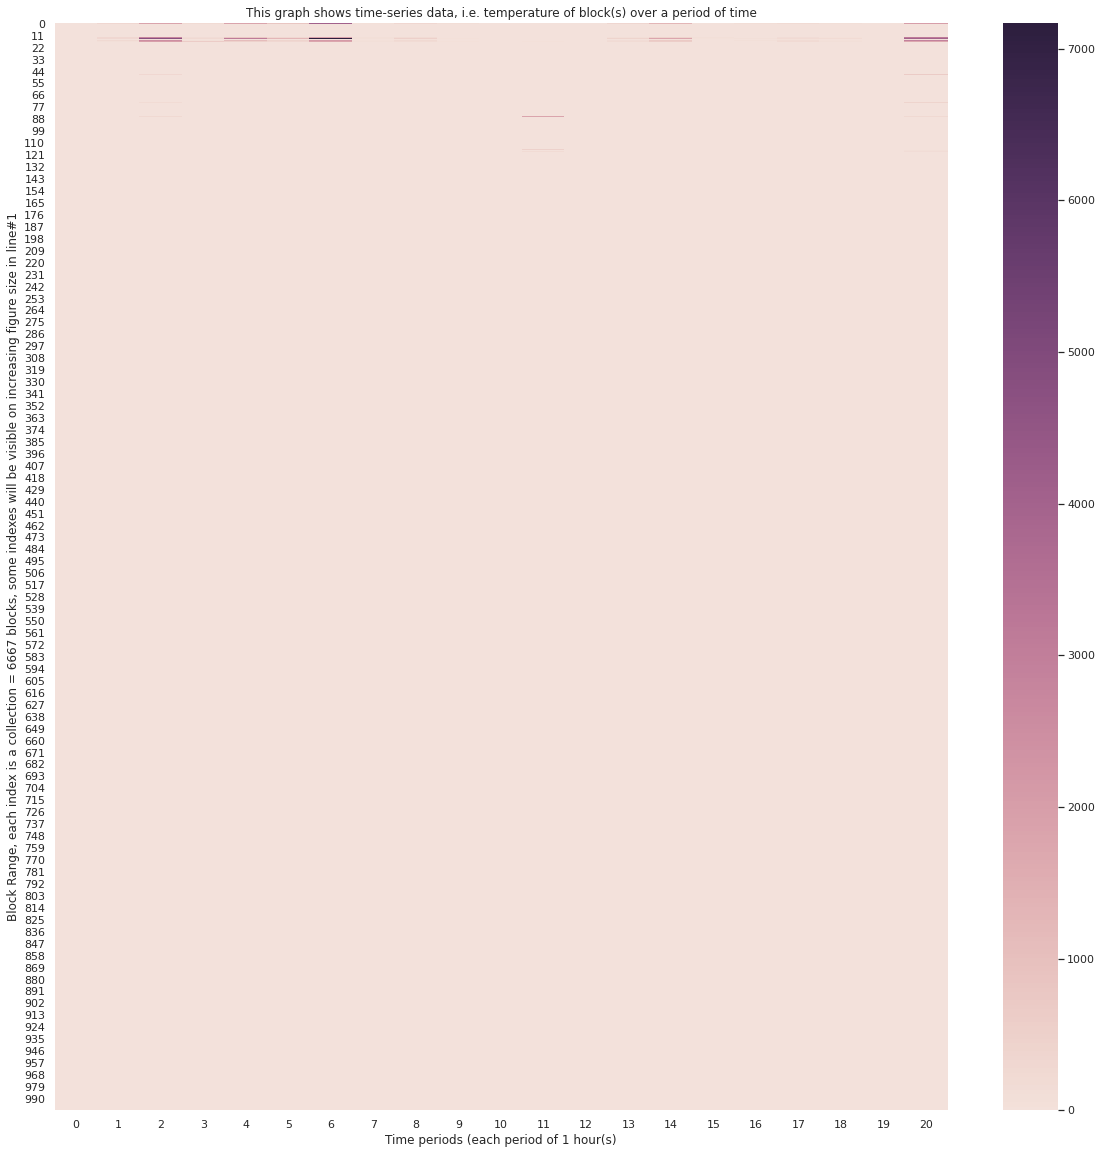

In [11]:
sns.set(rc={'figure.figsize':(20,20)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)

heatmap = sns.heatmap(result_df, cmap=cmap_i)
plt.xlabel('Time periods (each period of %s hour(s)' % set_hours)
plt.ylabel('Block Range, each index is a collection = %d blocks, some indexes will be visible on increasing figure size in line#1' % block_range_size)

plt.title('This graph shows time-series data, i.e. temperature of block(s) over a period of time')
plt.show()


### Plot of number of reads and writes wrt each block

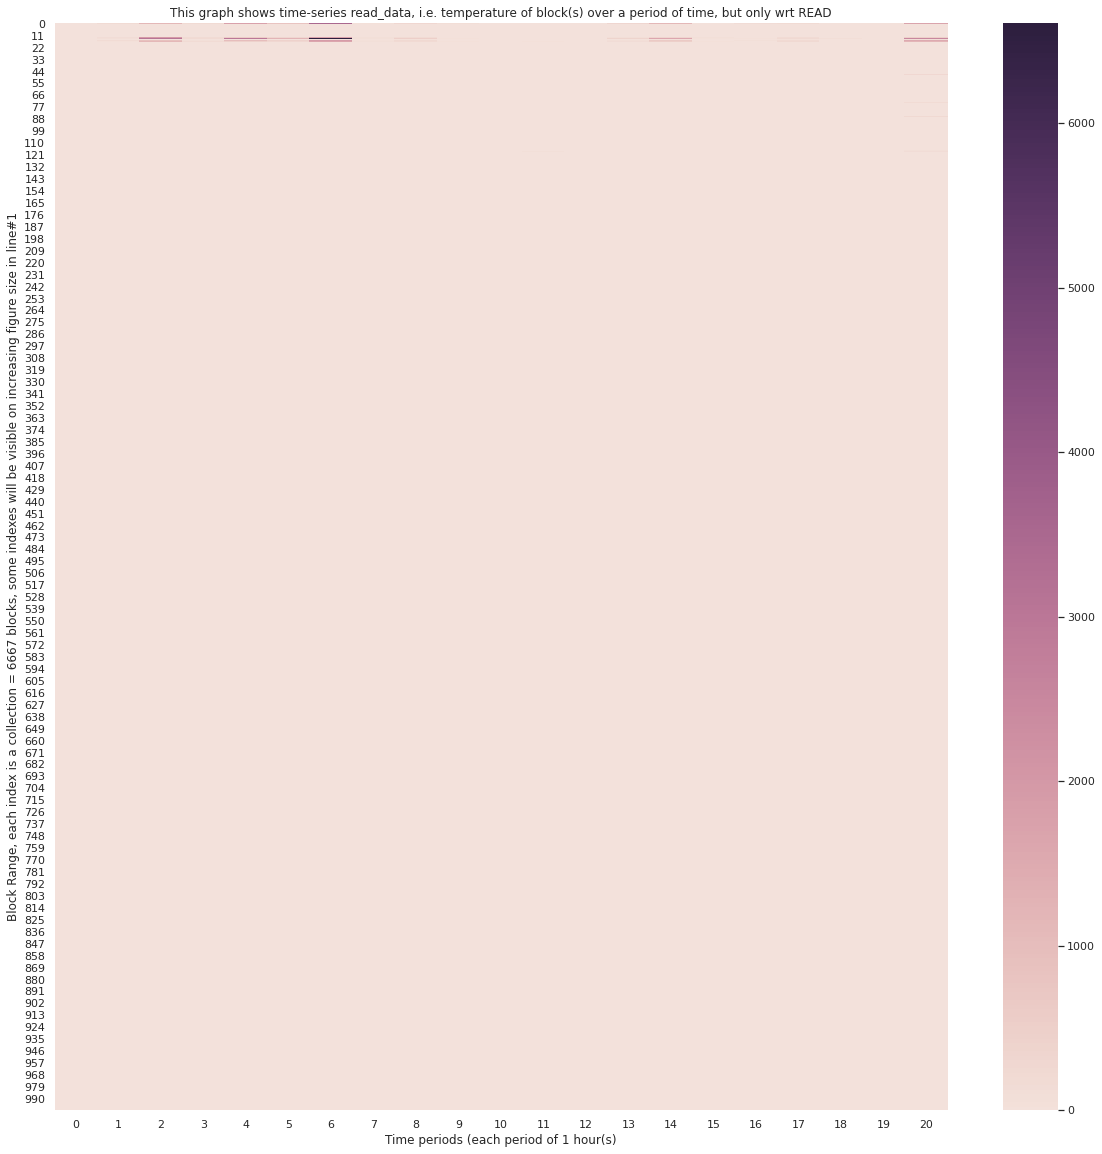

In [12]:
sns.set(rc={'figure.figsize':(20,20)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)

heatmap = sns.heatmap(result_read_df, cmap=cmap_i)
plt.xlabel('Time periods (each period of %s hour(s)' % set_hours)
plt.ylabel('Block Range, each index is a collection = %d blocks, some indexes will be visible on increasing figure size in line#1' % block_range_size)

plt.title('This graph shows time-series read_data, i.e. temperature of block(s) over a period of time, but only wrt READ')
plt.show()


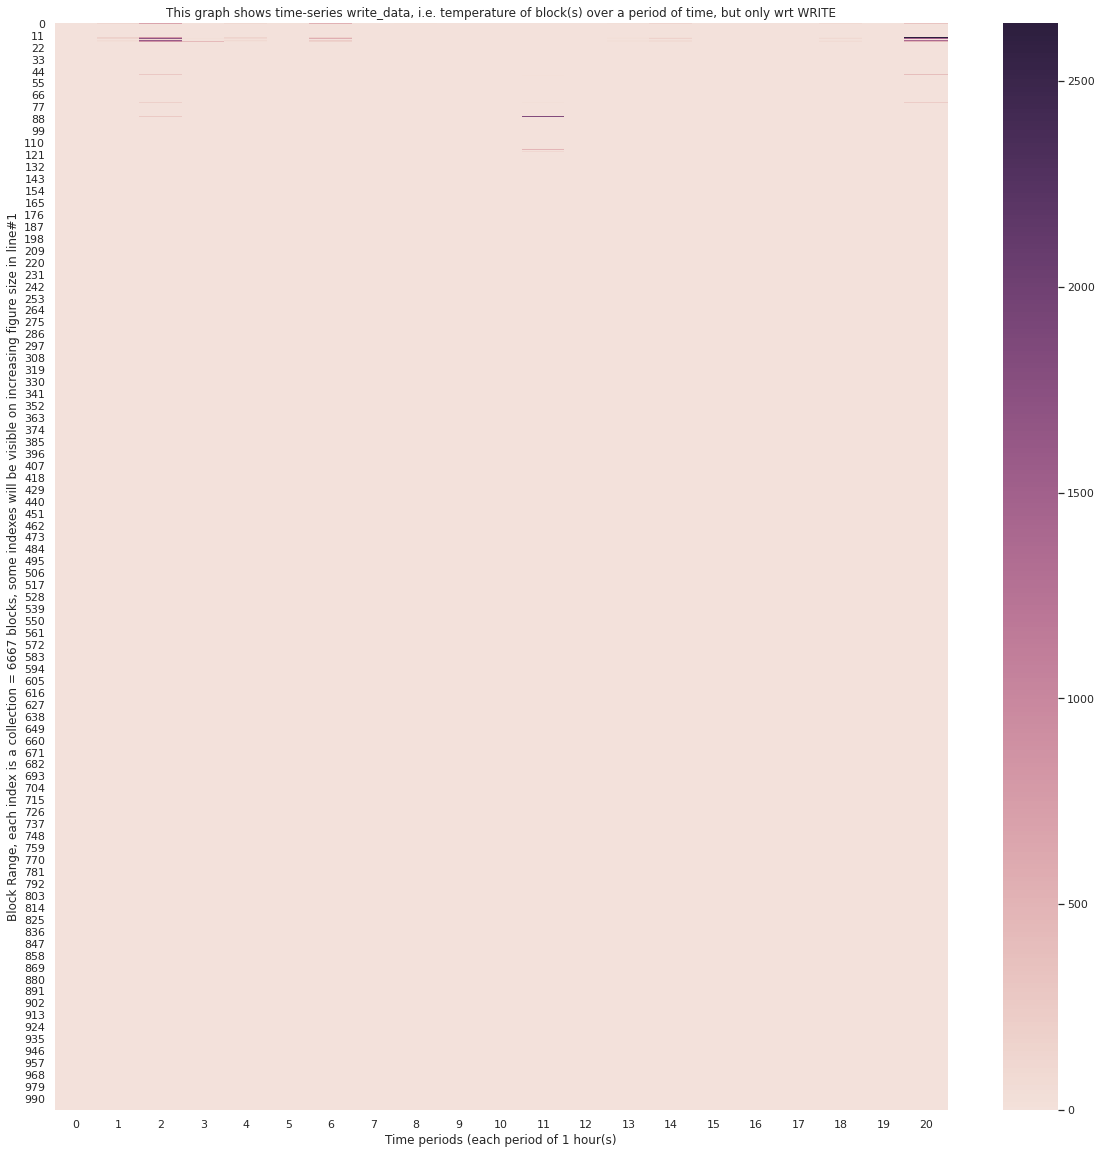

In [13]:
sns.set(rc={'figure.figsize':(20,20)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)

heatmap = sns.heatmap(result_write_df, cmap=cmap_i)
plt.xlabel('Time periods (each period of %s hour(s)' % set_hours)
plt.ylabel('Block Range, each index is a collection = %d blocks, some indexes will be visible on increasing figure size in line#1' % block_range_size)

plt.title('This graph shows time-series write_data, i.e. temperature of block(s) over a period of time, but only wrt WRITE')
plt.show()


## Extras

In [116]:
print(convert_filetime_to_datetime(128166477394345573))
print(len(block_counter_dict) // 100)


2007-02-22 19:55:39.434557
517


In [ ]:
sorted_df.index[-1]